In [1]:
# !pip uninstall virny -y

In [2]:
# Install using an HTTP link
# !pip install git+https://github.com/DataResponsibly/Virny.git@feature/add_datasets_for_benchmark

# Install using an SSH link
# !pip install git+ssh://git@github.com/DataResponsibly/Virny.git@feature/add_datasets_for_benchmark

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from virny.utils.data_viz_utils import create_dataset_stats_bar_chart

from configs.data_loaders import GermanCreditDataset
from EDA_utils import get_correlation_with_target, get_correlation_matrix, get_features_by_target_correlation_threshold

## Load dataset

In [6]:
DATASET_SPLIT_SEED = 100
MODELS_TUNING_SEED = 100
TEST_SET_FRACTION = 0.3
DATASET_NAME = 'German_Credit'

sensitive_attributes_dct = {'sex': 'female', 'age': [i for i in range(19, 26)], 'sex & age': None}
sensitive_attributes = [attr for attr in sensitive_attributes_dct.keys() if '&' not in attr]

In [7]:
data_loader = GermanCreditDataset()
data_loader.full_df.head()

,checking-account,duration,credit-history,purpose,credit-amount,savings-account,employment-since,installment-rate,other-debtors,residence-since,...,other-installment,housing,existing-credits,job,number-people-provide-maintenance-for,telephone,foreign-worker,sex,marital-status,class-label
0,<0 DM,6,1,radio/television,1169,NaN,>=7 years,4,none,4,...,none,own,2,1,1,yes,yes,male,divorced/separated,1
1,0 <= <200 DM,48,2,radio/television,5951,<100 DM,1<= < 4 years,2,none,2,...,none,own,1,1,1,none,yes,female,divorced/separated,0
2,no account,12,1,education,2096,<100 DM,4<= <7 years,2,none,3,...,none,own,1,2,2,none,yes,male,divorced/separated,1
3,<0 DM,42,2,furniture/equipment,7882,<100 DM,4<= <7 years,2,guarantor,4,...,none,for free,1,1,2,none,yes,male,divorced/separated,1
4,<0 DM,24,3,car (new),4870,<100 DM,1<= < 4 years,3,none,4,...,none,for free,2,1,2,none,yes,male,divorced/separated,0


In [8]:
data_loader.target

'class-label'

In [9]:
data_loader.full_df.shape

(1000, 22)

In [10]:
data_loader.full_df.isnull().sum()

checking-account                           0
duration                                   0
credit-history                             0
purpose                                    0
credit-amount                              0
savings-account                          183
employment-since                           0
installment-rate                           0
other-debtors                              0
residence-since                            0
property                                 154
age                                        0
other-installment                          0
housing                                    0
existing-credits                           0
job                                        0
number-people-provide-maintenance-for      0
telephone                                  0
foreign-worker                             0
sex                                        0
marital-status                             0
class-label                                0
dtype: int

## Check proportions and base rates

In [11]:
create_dataset_stats_bar_chart(data_loader.X_data, data_loader.y_data, sensitive_attributes_dct)

alt.FacetChart(...)

### Data Profiling

In [12]:
for col in data_loader.categorical_columns:
    print(f'{col}: {len(data_loader.full_df[col].unique())}')

checking-account: 4
credit-history: 5
purpose: 10
savings-account: 5
employment-since: 5
other-debtors: 3
property: 4
other-installment: 3
housing: 3
job: 4
telephone: 2
foreign-worker: 2
sex: 2
marital-status: 2


In [13]:
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories='auto', handle_unknown='ignore', sparse=False), data_loader.categorical_columns)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)
column_transformer = column_transformer.set_output(transform="pandas")  # Set transformer output to a pandas df

In [14]:
full_processed_df = column_transformer.fit_transform(data_loader.full_df)
list(full_processed_df.columns)

['checking-account_0 <= <200 DM',
 'checking-account_<0 DM',
 'checking-account_>= 200 DM ',
 'checking-account_no account',
 'credit-history_1',
 'credit-history_2',
 'credit-history_3',
 'credit-history_4',
 'credit-history_5',
 'purpose_business',
 'purpose_car (new)',
 'purpose_car (used)',
 'purpose_domestic appliances',
 'purpose_education',
 'purpose_furniture/equipment',
 'purpose_others',
 'purpose_radio/television',
 'purpose_repairs',
 'purpose_retraining',
 'savings-account_100 <= <500 DM',
 'savings-account_500 <= < 1000 DM',
 'savings-account_<100 DM',
 'savings-account_>= 1000 DM',
 'savings-account_nan',
 'employment-since_1<= < 4 years',
 'employment-since_4<= <7 years',
 'employment-since_<1 years',
 'employment-since_>=7 years',
 'employment-since_unemployed',
 'other-debtors_co-applicant',
 'other-debtors_guarantor',
 'other-debtors_none',
 'property_1',
 'property_2',
 'property_4',
 'property_nan',
 'other-installment_bank',
 'other-installment_none',
 'other-inst

### Correlation of sensitive attributes with the target

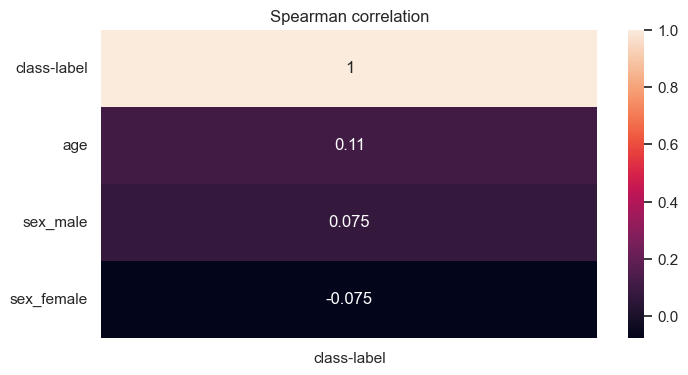

In [15]:
get_correlation_with_target(df=full_processed_df,
                            target_name=data_loader.target,
                            feature_names=[col for col in full_processed_df.columns \
                                           if col != data_loader.target \
                                           and (col.startswith(sensitive_attributes[0]) or col.startswith(sensitive_attributes[1]))
                                           ],
                            heatmap_size=(4, 8))

### Correlation of selected attributes with the target

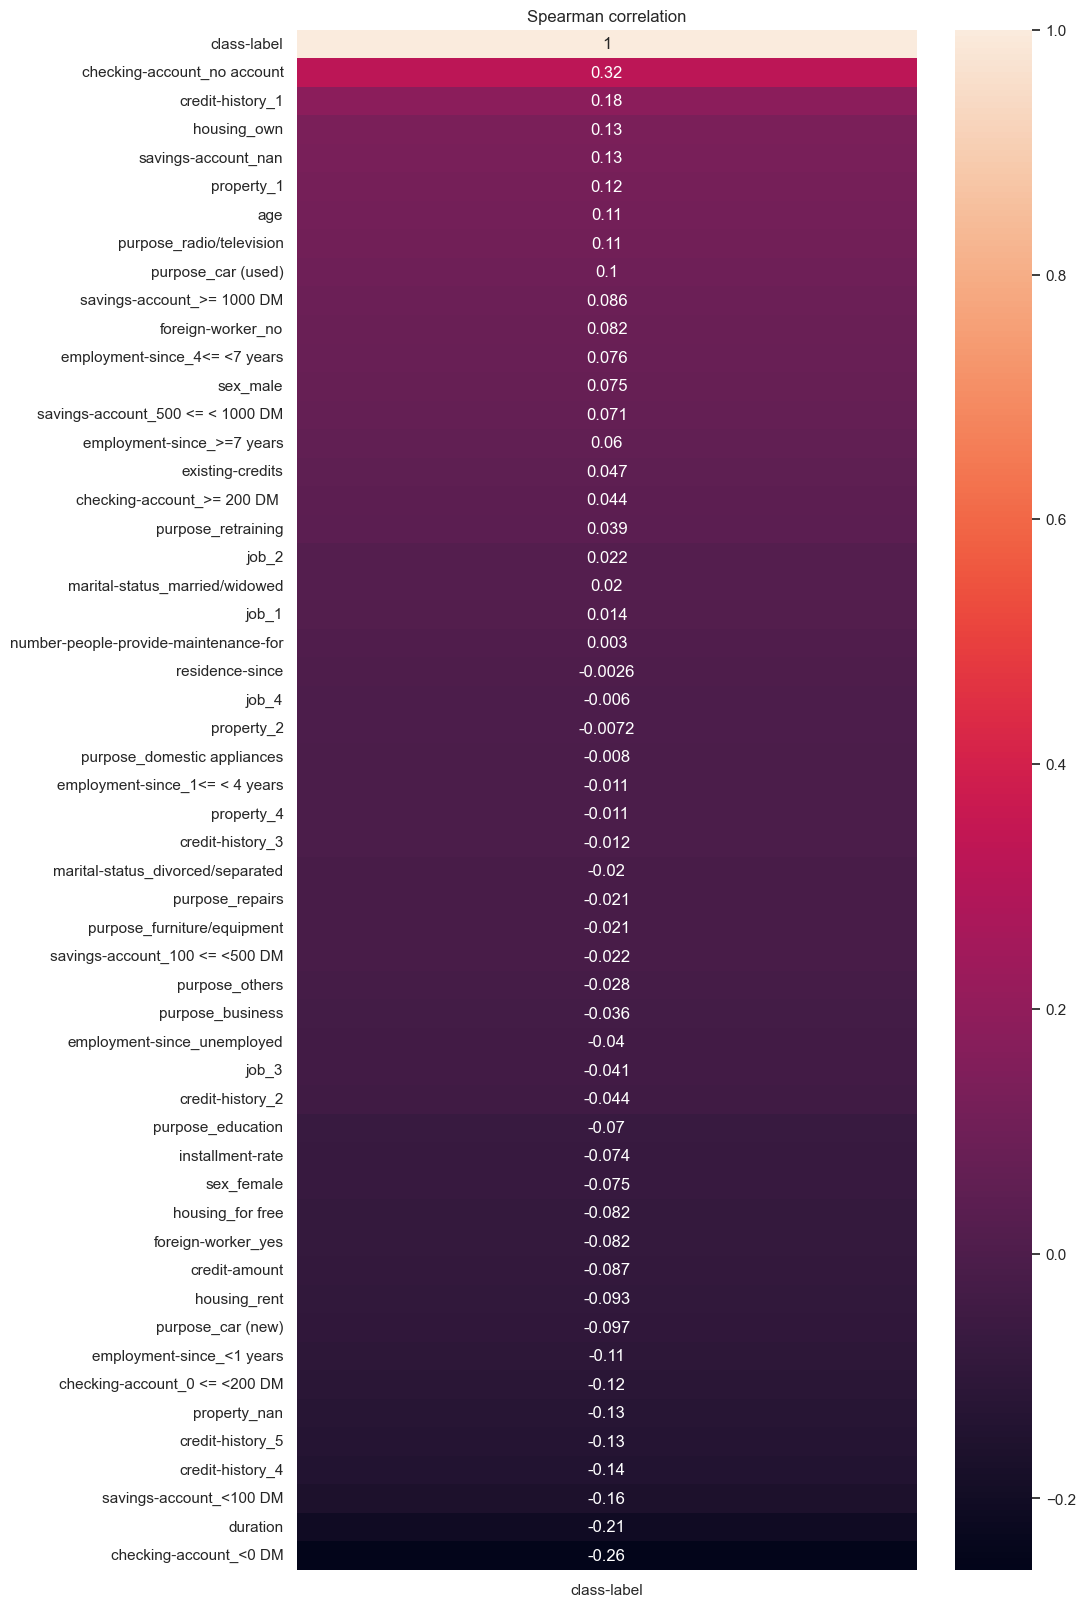

In [16]:
filtered_feature_names = [col for col in full_processed_df.columns 
                          if col != data_loader.target
                            and not col.startswith('other-installment')
                            and not col.startswith('other-debtors')
                            and not col.startswith('telephone')]
get_correlation_with_target(df=full_processed_df,
                            target_name=data_loader.target,
                            feature_names=filtered_feature_names,
                            heatmap_size=(20, 10))

### Correlation matrix for features which have high correlation with the target

In [17]:
high_correlated_features = get_features_by_target_correlation_threshold(
    df=full_processed_df[filtered_feature_names + [data_loader.target]],
    target=data_loader.target,
    threshold=0.12
)
high_correlated_features

['checking-account_<0 DM',
 'checking-account_no account',
 'credit-history_1',
 'credit-history_4',
 'credit-history_5',
 'savings-account_<100 DM',
 'savings-account_nan',
 'property_nan',
 'housing_own',
 'duration']

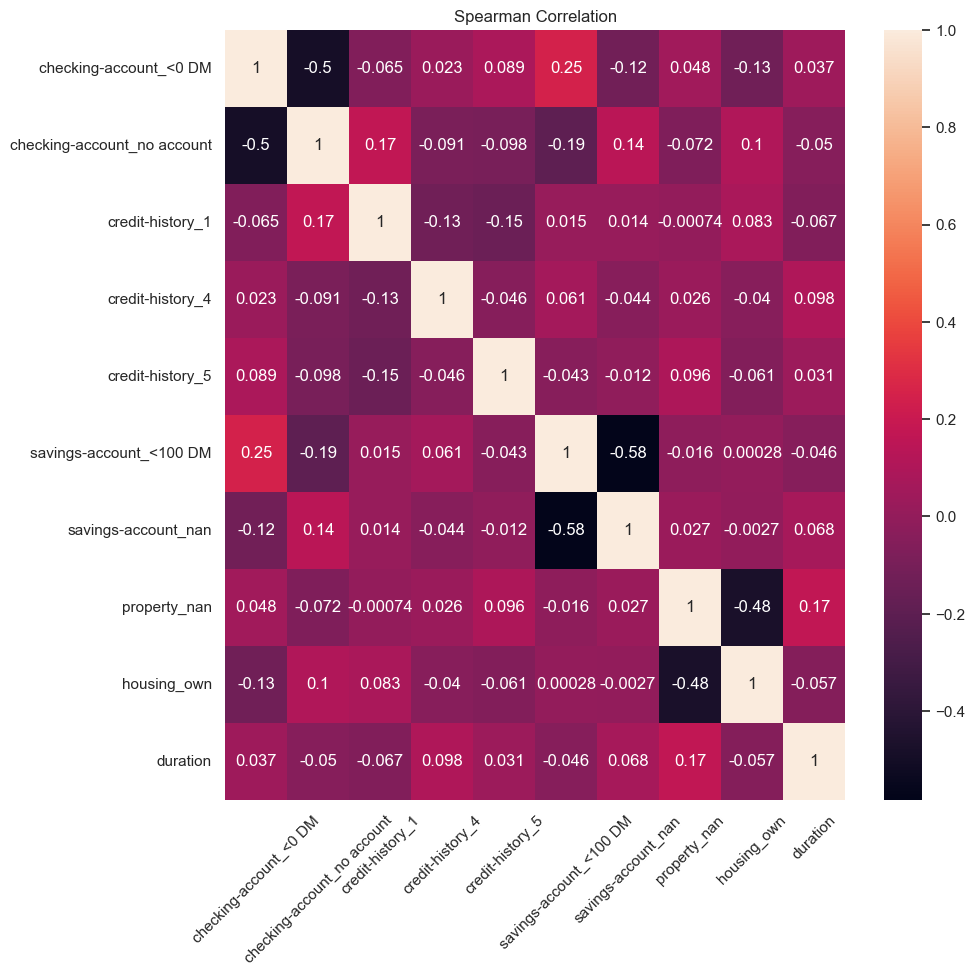

In [18]:
get_correlation_matrix(df=full_processed_df,
                       feature_names=high_correlated_features,
                       heatmap_size=(10, 10))